## Query by Fundamental Parameters with SIMPLE

## Imports

In [1]:
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from specutils import Spectrum

from sqlalchemy import and_, or_
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
plt.rcParams['font.family'] = 'serif'

## Load the Database

In [ ]:
# Load in the database
from astrodb_utils import load_astrodb
from simple import REFERENCE_TABLES

SCHEMA_PATH = "../../simple/schema.yaml" 
recreatedb = False #Set to True or False
db = load_astrodb(
     "../../SIMPLE.sqlite", 
     recreatedb=recreatedb,  
     reference_tables=REFERENCE_TABLES, 
     felis_schema=SCHEMA_PATH
     )

## Query by Fundamental Parameter

Lets try plotting spectra from multiple sources using a couple different metrics we can decide on within SIMPLE

To further understand what different ways you can query obects you can reference the schema in simple/schema.yaml and for a visual reference the github documentation: https://github.com/SIMPLE-AstroDB/SIMPLE-db/tree/main/docs

In [27]:
# Create a query to join ModeledParameters and Spectra tables
# This will find all spectra for sources with T_eff between 1100-1200K
spectra_temp_query = """
SELECT 
    mp.source, 
    mp.parameter,
    mp.value,
    s.regime, 
    s.instrument, 
    s.telescope, 
    s.access_url

FROM ModeledParameters mp
JOIN Spectra s ON mp.source = s.source
WHERE mp.parameter = 'T eff' 
    AND mp.value BETWEEN 1300 AND 1350
ORDER BY mp.value, mp.source, s.regime
"""

# Execute the query
low_temp = db.sql_query(spectra_temp_query, fmt='pandas')
print(f"Found {len(low_temp)} spectra for sources with T_eff between 1200-1300K within SIMPLE.") #How many spectra did we find?
print(f"Found {len(low_temp['source'].unique())} unique sources.") #How many unique sources did we find?

Found 55 spectra for sources with T_eff between 1200-1300K within SIMPLE.
Found 20 unique sources.


In [28]:
# Filter the fits_spectra DataFrame to only include rows where access_url ends with "fits"
fits_spectra = low_temp[low_temp['access_url'].str.endswith('fits')]
fits_spectra = fits_spectra.reset_index(drop=True)
print(fits_spectra)
print(fits_spectra['telescope'].unique())

                      source parameter   value   regime instrument  \
0     2MASSI J2254188+312349     T eff  1300.0      mir        IRS   
1   SDSS J151643.01+305344.4     T eff  1300.0      mir        IRS   
2    SIMP J013656.5+093347.3     T eff  1300.0      mir        IRS   
3    SIMP J013656.5+093347.3     T eff  1300.0      nir   XShooter   
4    SIMP J013656.5+093347.3     T eff  1300.0  optical   XShooter   
5    2MASS J05591914-1404488     T eff  1301.0      mir        IRS   
6    2MASS J05591914-1404488     T eff  1301.0      nir       SpeX   
7    2MASS J10430758+2225236     T eff  1301.0      nir       SpeX   
8    2MASS J10430758+2225236     T eff  1301.0  optical     GMOS-N   
9    2MASS J14482563+1031590     T eff  1315.0      mir        IRS   
10   2MASS J14482563+1031590     T eff  1315.0      nir       SpeX   
11   2MASS J14482563+1031590     T eff  1315.0  optical   R-C Spec   
12   2MASS J02050344+1251422     T eff  1321.0      nir       SpeX   
13   2MASS J02050344

## Plotting

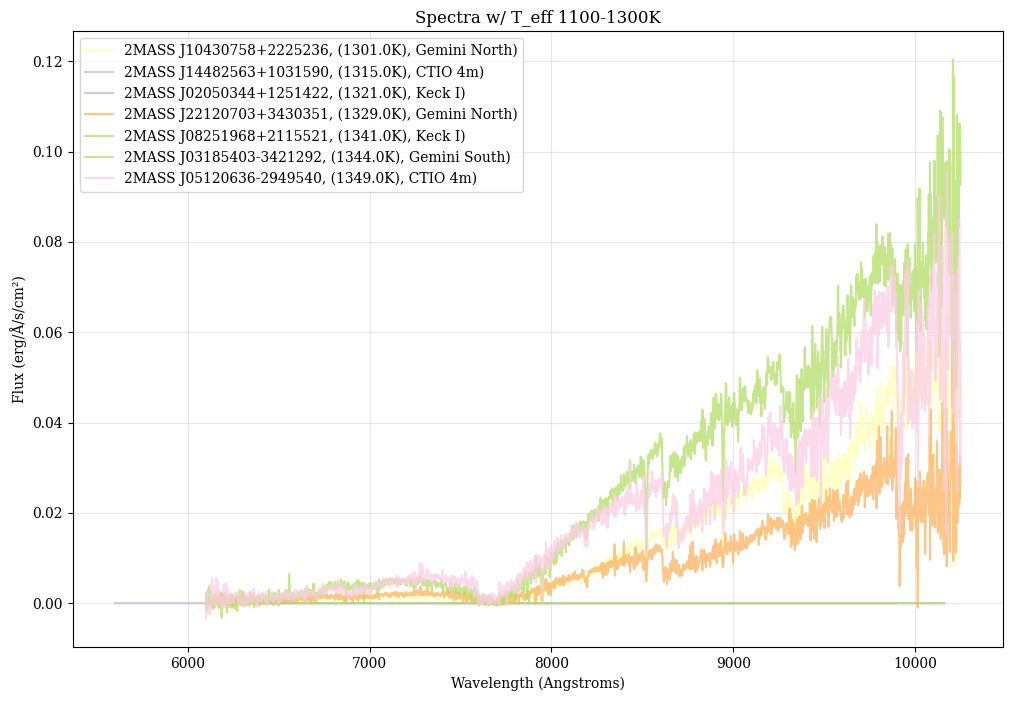

In [42]:
import matplotlib.pyplot as plt
from specutils import Spectrum1D
import astropy.units as u
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(12, 8))

# Create a colormap to assign different colors to each spectrum
n = 20
colors = cm.Set3(np.linspace(0, 1, 55))

# Loop through spectra
for i in range(len(fits_spectra)):
    source = fits_spectra.iloc[i]['source']
    temp = fits_spectra.iloc[i]['value']

    try:
        spec = Spectrum.read(fits_spectra.iloc[i]['access_url'], format = "wcs1d-fits")
        plt.plot(spec.spectral_axis, spec.flux, label=f"{source}, ({temp}K), {fits_spectra.iloc[i]['telescope']})", color = colors[i],  alpha = 0.75)
    except Exception as e:
        continue
            

plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/Å/s/cm²)')
plt.title('Spectra w/ T_eff 1100-1300K')
plt.legend()
# plt.yscale('log')
# plt.ylim(10e-8, 10) 
# plt.xlim(0.50, 1.5)
plt.grid(True, alpha=0.3)
plt.show()



## Bonus Example, Query by Count

Using SQL_Query (https://astrodbkit.readthedocs.io/en/latest/astrodb.html#astrodbkit.astrodb.Database.sql_query) we can pull out the values for various modelled parameters and visualize them together to get trends in the data. Lets take this example of comparing temperature to mass for objects with recorded modelled parameters for both. 


Found 2692 objects with values for both Temperature and Mass.


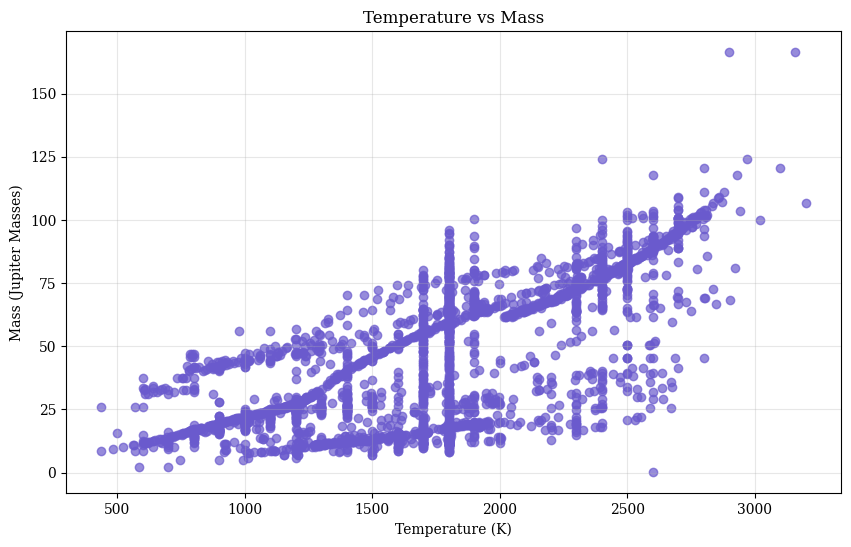

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Get data from database
query = """
SELECT 
    s1.source, 
    s1.value as temperature, 
    s2.value as mass
FROM ModeledParameters s1
JOIN ModeledParameters s2 ON s1.source = s2.source
WHERE s1.parameter = 'T eff' AND s2.parameter = 'mass'
"""

# Load data into a table
data = db.sql_query(query, fmt='pandas')
data.columns = ['Source', 'Temperature', 'Mass']
print(f"Found {len(data)} objects with values for both Temperature and Mass.")

# Make the plot
plt.figure(figsize=(10, 6))
plt.scatter(data['Temperature'], data['Mass'], alpha=0.7, color = "slateblue")

plt.xlabel('Temperature (K)')
plt.ylabel('Mass (Jupiter Masses)')
plt.title('Temperature vs Mass')
plt.grid(True, alpha=0.3)

plt.show()